# Visualize Vision/Language Attention from Language

In order to finetune language specification and verify which model gives the best spatial guidance, this notebook compute attention for individual images. 

All the important attention generation code is in [attention_utils.py](../utils/attention_utils.py)

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
import torchvision
import random
import pandas as pd
from omegaconf import OmegaConf

from torchray.attribution.grad_cam import grad_cam as tr_gradcam

import matplotlib
matplotlib.rcParams.update({'font.size': 18})
import cv2
import matplotlib.pyplot as plt

import os
if os.getcwd().split(os.sep)[-1] == 'notebooks':
    os.chdir('..')
print(os.getcwd())

from attention.grad_cam import GradCAM
from CLIP.clip import clip

from utils import attention_utils as au
from datasets.waterbirds import Waterbirds as Dataset
from datasets import normalizations

/shared/lisabdunlap/vl-attention


### Load Data

Here we choose Waterbirds but you can swap in your favorite config or random images from the internet, up to you. 

In [2]:
cfg_file  = 'configs/waterbirds_generic.yaml'
base_cfg  = OmegaConf.load('configs/base.yaml')
cfg       = OmegaConf.load(cfg_file)
cfg.DATA.SUBDIR = 'waterbirds'
args = OmegaConf.merge(base_cfg, cfg)
    
mean, std = normalizations.normalizations[args.DATA.NORMALIZATION]['mean'], \
                    normalizations.normalizations[args.DATA.NORMALIZATION]['std']
train_transform = transforms.Compose([
    transforms.Resize((args.DATA.SIZE, args.DATA.SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

 
transform = None
train_dataset = Dataset(root='./data',
                  cfg=args,
                  transform=None,
                  split='train')

WATERBIRDS DIR: ./data/waterbird_complete95_forest2water2
NUMBER OF SAMPLES WITH LABEL Landbird: 3682
NUMBER OF SAMPLES WITH LABEL Waterbird: 1113
NUMBER OF SAMPLES WITH GROUP Land_on_Land: 3498
NUMBER OF SAMPLES WITH GROUP Land_on_Water: 184
NUMBER OF SAMPLES WITH GROUP Water_on_Land: 56
NUMBER OF SAMPLES WITH GROUP Water_on_Water: 1057


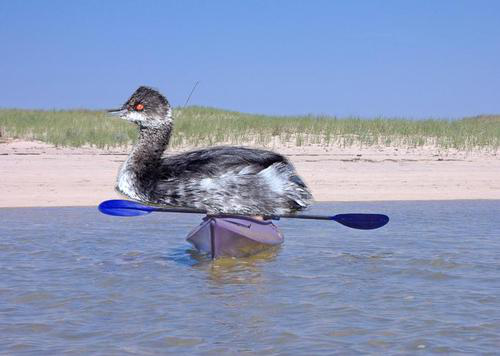

In [4]:
# randomly pick an image (note we only need the image path)
sample_idx = np.random.choice(list(range(len(train_dataset))))
sample = train_dataset[sample_idx]
sample['image']

### Prompt Tinkering

Here we try a few different prompts in order to see which is best. Note that you can also opt to combine the attention from mutliple prompts as we did in the paper. 

In [3]:
prompts = ['a photo of a bird', 'an image of a bird']

#### Generate CLIP ViT Attention

*Note:* the number below the prompt is the softmax of the cosine similarities between the image and text embeddings

/home/lisabdunlap/anaconda3/lib/python3.8/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


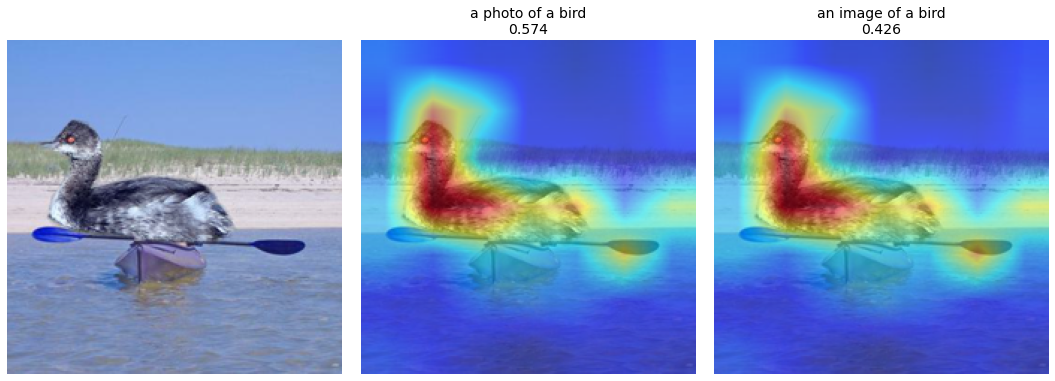

In [5]:
model, preprocess = clip.load('ViT-B/32', device='cuda', jit=False)
tokenized_text = clip.tokenize(list(prompts)).to('cuda')
transform = preprocess

attention = au.transformer_attention(
                model, transform, sample['image_path'],
                text_list=list(prompts),
                tokenized_text=tokenized_text,
                device='cuda',
                plot_vis=True,
                save_vis_path='./',
                resize=False
            )

#### Generate CLIP RN50 Attention

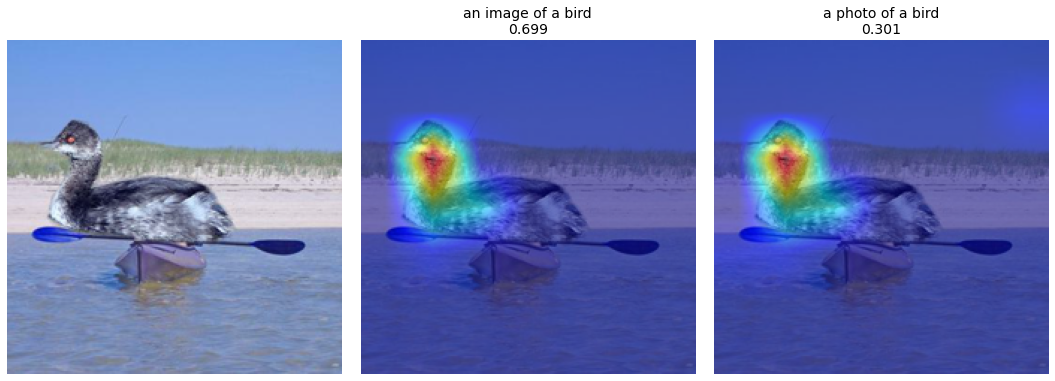

In [6]:
model, preprocess = clip.load('RN50', device='cuda', jit=False)
attention = au.clip_gcam(
                model, transform, sample['image_path'],
                text_list=list(prompts),
                tokenized_text=tokenized_text,
                layer='layer4.2.relu',
                device='cuda',
                plot_vis=True,
                save_vis_path='./',
                resize=False,
            )